# <center>Cassava Plant Leaf Disease Classification 

<img style="float: center;" src="images/leaves.jfif">

## About Cassava Plants

As the second-largest provider of carbohydrates in Africa, cassava is a key food security crop grown by smallholder farmers because it can withstand harsh conditions. At least 80% of household farms in Sub-Saharan Africa grow this starchy root, but viral diseases are major sources of poor yields.

## Importing Libraries and Data

In [89]:
import os
import glob
import json
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as k
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# remove warnings (most of them are not critical and meant for debugging tensorflow)
import warnings
warnings.filterwarnings("ignore")

### Mixed precision to speedup training.
**You Need GPU compute capability of at least 7.0, Remove the below cell if that isn't the case.For more information refer __[this](https://docs.nvidia.com/deeplearning/performance/mixed-precision-training/index.html)__**

In [90]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [91]:
train_path = 'train_images/'
data = pd.read_csv('train.csv')
data.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


## Exploratory Data Analysis

**Let's convert the labels to meaningful class names for better understanding.**

In [92]:
f = open('label_num_to_disease_map.json')
real_labels = json.load(f)
real_labels = {int(k):v for k,v in real_labels.items()}

data['class_name'] = data['label'].map(real_labels)
data.head()

,image_id,label,class_name
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)


**Let's see what classes are present in the database.**

In [93]:
pd.DataFrame(real_labels.items(),columns=['Labels','Disease Name'])

,Labels,Disease Name
0,0,Cassava Bacterial Blight (CBB)
1,1,Cassava Brown Streak Disease (CBSD)
2,2,Cassava Green Mottle (CGM)
3,3,Cassava Mosaic Disease (CMD)
4,4,Healthy


**Let's have a looking on the distribution of the classes in the dataset**

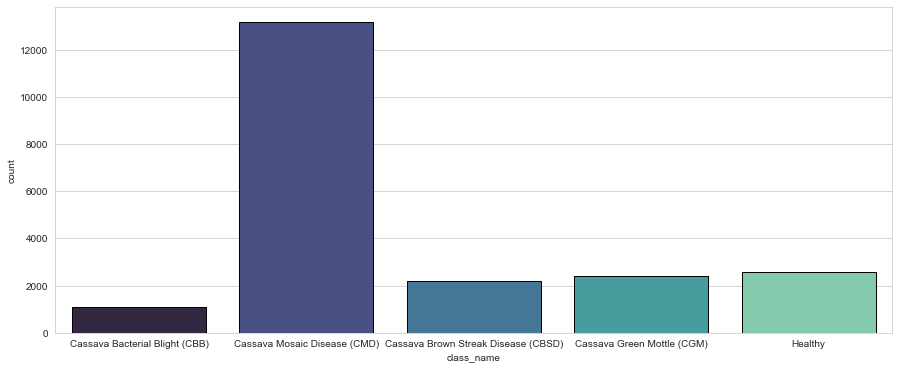

In [94]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,6))
sns.countplot(data["class_name"], edgecolor="black", palette="mako")
plt.show()

In [95]:
perc_CMD = (data['label'].value_counts()[3]/np.sum(data['label'].value_counts()))*100
print(perc_CMD)

61.49460204701593


### Key Insights:
- Cassava Mosaic Disease (CMD) is the dominant class in the training set constituting  **61.5%** of the total data.
- The dataset is very skewed so there might be a need of upsampling or undersampling.

### Experiment 1

**The test data for the competetion is private and only available after submitting out kernel. Lets test out whether the test set is skewed as well. For this we will predict all the data to be the dominant class: CMD (3).**

In [96]:
# TEST_DIR = 'test_images/'
# test_images = os.listdir(TEST_DIR)
# predictions = []

# for image in test_images:
#     predictions.append(3)

# sub = pd.DataFrame({'image_id': test_images, 'label': predictions})
# sub.to_csv('submission.csv', index = False)

**Surprisingly The score came out to be 0.60,This means even the test set is very much skewed, CMD seems to be a very common disease**

<img style="float: left;" src="images/naive_score.png"></img>

****

### Let's Have a look at the images of different classes
**Label 0 : Cassava Bacterial Blight (CBB)**

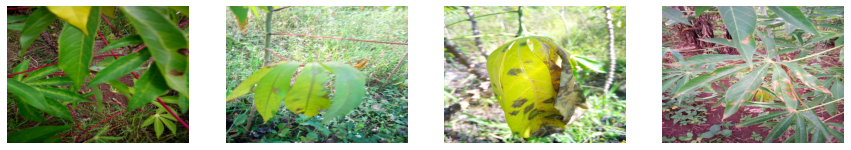

In [97]:
df0 = data[data["label"] == 0]
files = df0["image_id"].sample(4).tolist()

plt.figure(figsize=(15,5))
index = 0
for file in files:
    image = Image.open(train_path + file)
    plt.subplot(1, 4, index + 1)
    plt.imshow(image)
    plt.axis("off")
    index += 1

plt.show()

**Label 1: Cassava Brown Streak Disease (CBSD)**

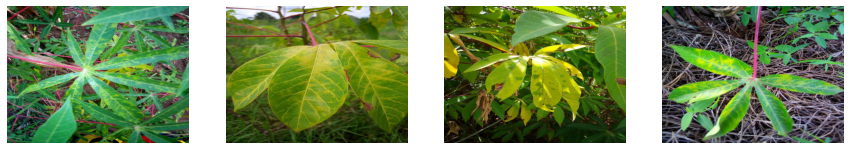

In [98]:
df0 = data[data["label"] == 1]
files = df0["image_id"].sample(4).tolist()

plt.figure(figsize=(15,5))
index = 0
for file in files:
    image = Image.open(train_path + file)
    plt.subplot(1, 4, index + 1)
    plt.imshow(image)
    plt.axis("off")
    index += 1

plt.show()

**Label 2: Cassava Green Mottle (CGM)**

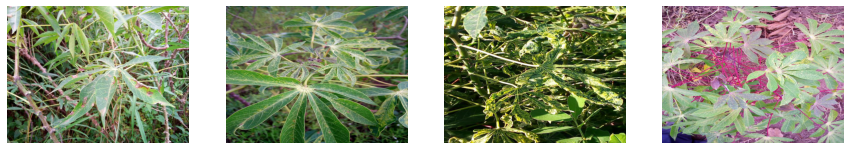

In [99]:
df0 = data[data["label"] == 2]
files = df0["image_id"].sample(4).tolist()

plt.figure(figsize=(15,5))
index = 0
for file in files:
    image = Image.open(train_path + file)
    plt.subplot(1, 4, index + 1)
    plt.imshow(image)
    plt.axis("off")
    index += 1

plt.show()

**Label 3: Cassava Mosaic Disease (CMD)**

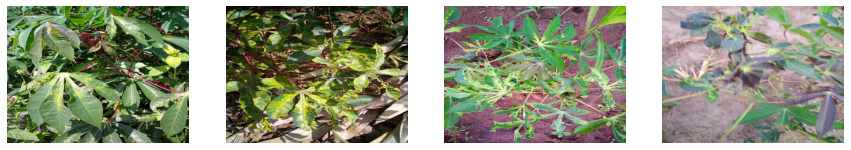

In [100]:
df0 = data[data["label"] == 3]
files = df0["image_id"].sample(4).tolist()

plt.figure(figsize=(15,5))
index = 0
for file in files:
    image = Image.open(train_path + file)
    plt.subplot(1, 4, index + 1)
    plt.imshow(image)
    plt.axis("off")
    index += 1

plt.show()

**Label 4: Healthy**

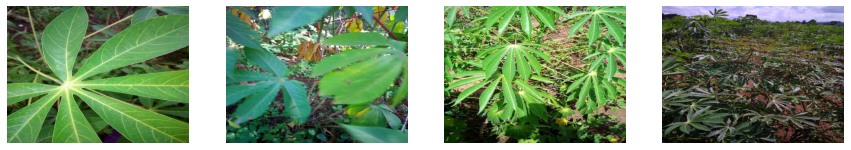

In [101]:
df0 = data[data["label"] == 4]
files = df0["image_id"].sample(4).tolist()

plt.figure(figsize=(15,5))
index = 0
for file in files:
    image = Image.open(train_path + file)
    plt.subplot(1, 4, index + 1)
    plt.imshow(image)
    plt.axis("off")
    index += 1

plt.show()

**Note:** There are many noisy labels in our dataset. To mitigate this we will be using label smoothing and Bi-Tempered Logistic loss, as we will see in the later parts of the notebook.

In [102]:
# this is important, adjust image size to fit your memory.
IMG_SIZE = 512
size = (IMG_SIZE,IMG_SIZE)
# number of classes
n_CLASS = 5
# choose batch size according to available VRAM
BATCH_SIZE = 2  #reduce this if you get a OOM(out of memory error)

# number of epochs
EPOCHS = 40

###  Image Augumentation

#### What is it?
Generally in cases where the trainset is really small or mostly similar, we can articficially generate more train and test images by slightly changing the color, random rotation, shifts, shear and flips etc. Be careful not to change the image too much as it can be misleading for our model.
Image augumentation on small datasets boosts the models performace.

#### Why is it important in this case?
This dataset is not very small but not very large either. Mostly I use this because this gave a boost in Leaderboard score and Cross Validation accuracy. This can be experimental as well. It is a good practice to do image augumentation for better generalization.

**Install ImageDataAugumentor**

This is only one time step if on a local machine, If on kaggle kernel/colab notebook, do this every new session.

In [103]:
# !pip install git+https://github.com/mjkvaak/ImageDataAugmentor

We will use **Albumentations** library, It is a very popular image augumentation library.
For a quickstart guide follow [this](https://analyticsindiamag.com/hands-on-guide-to-albumentation/)

In [104]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as A


# add as many alteration you want here, dont meddle with validation data much 
# as we won't be doing TTA(test time augumentation)for now. TTA seems to imrove LB score, but I will skip this here.

train_augmentations = A.Compose([
            A.RandomCrop(IMG_SIZE, IMG_SIZE, p=1),
            A.CoarseDropout(p=0.5),
            A.Cutout(p=0.5),
            A.Flip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.HueSaturationValue(p=0.5, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
            A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2)),
            A.ToFloat()
            ], p=1)

val_augmentations = A.Compose([
                A.CenterCrop(IMG_SIZE, IMG_SIZE, p=1),
                A.ToFloat()
                ], p=1)

# Train and validation data Generators
datagen_train = ImageDataAugmentor(augment=train_augmentations)
datagen_val = ImageDataAugmentor(augment=val_augmentations)

**Now let's feed data to above generator**

In [105]:
def DataGenerator(train,val):
    train_set = datagen_train.flow_from_dataframe(train,
                                 directory = train_path,
                                 seed=7,
                                 x_col = 'image_id',
                                 y_col = 'class_name',
                                 target_size = size,
                                 class_mode = 'categorical',
    #                              interpolation = 'nearest',  #avoid this when using albumentation(interpolation integer error)
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

    val_set = datagen_val.flow_from_dataframe(val,
                                 directory = train_path,
                                 seed=7,
                                 x_col = 'image_id',
                                 y_col = 'class_name',
                                 target_size = size,
                                 class_mode = 'categorical',
    #                              interpolation = 'nearest',
                                 batch_size = BATCH_SIZE)
    return train_set,val_set

**Now let's check some images after augumentation**

In [106]:
train_temp = data.iloc[:10]
val_temp = data.iloc[-10:]
train_set_temp,val_set_temp = DataGenerator(train_temp,val_temp)

Found 10 validated image filenames belonging to 5 classes.
Found 10 validated image filenames belonging to 4 classes.


In [107]:
train_images, _ = next(train_set_temp)

plt.figure(figsize=(14, 14))
for i in range(9):
    image = train_images[i]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")

plt.show()

**Note:** While using this to display images beware that your batchsize is less than or equal to the total subplots in the above code.

In [108]:
val_images, _ = next(val_set_temp)

plt.figure(figsize=(14, 14))
for i in range(9):
    image = train_images[i]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")

plt.show()

## Model Building (Transfer Learning)

### Label Smoothing

As I pointed out earlier these data labels are noisy. Label smooting is a technique useed to cope up with such datasets. We will also see other solutions such as using Bi-Tempered Logistic loss as loss function in place of the categorical cross entropy that we use in general.

Label smoothing can be used with the inbuilt Categorical_crossentropy function that keras has.

#### How Label smoothing works?
Basically we say that we arent 100% confident in our labels. For example: For a digit recognition task, an image of 9 will have a one-hot encoded vector as follows [0,0,0,0,0,0,0,0,1]. This makes sense as well.
Let's say we aren't sure that our labels are correct in all the datapoints. lets say we use label smoothing with a value of 0.11

new_labels = onehot_labels * (1 - label_smoothing) + label_smoothing / num_classes

new_labels = [0,0,0,0,0,0,0,0,1]*(0.89)+0.012
new_labels = [0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.902]

This means that we are 90% confident in our labels.
The general rule of thumb is to take label smoothing as 1/n_classes. but this is value that must be derived after several experiments.

For more info on label smoothing : Refer [this](https://towardsdatascience.com/what-is-label-smoothing-108debd7ef06)

### K- Fold Cross Validation

We will also use K-Fold cross validation to train our model. We will use the stratifiedKfold function because of the skew in out data. This will preserve the ratio of each class in each fold.

<img style="float: left;" src="images/cross_validation.png">

For more infomation refer [this](https://medium.com/datadriveninvestor/k-fold-cross-validation-6b8518070833)

**Let's create all our models here.**

In [109]:
def create_model_resnet50():
    
    model = Sequential()
    model.add(ResNet50(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False, weights = 'imagenet'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
    model.add(Dropout(0.7))
    model.add(Dense(n_CLASS, activation = 'softmax',dtype='float32')) #this is very important to use mixed_precision
    
    return model

In [110]:
def create_model_vgg16():
    
    model = Sequential()
    model.add(VGG16(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False, weights = 'imagenet'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(n_CLASS, activation = 'softmax',dtype='float32')) #this is very important to use mixed_precision
    
    return model

In [111]:
def create_model_effnetb4():
    
    model = Sequential()
    model.add(EfficientNetB4(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False, weights = 'imagenet'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(n_CLASS, activation = 'softmax',dtype='float32')) #this is very important to use mixed_precision
    
    return model

In [ ]:
def create_model_effnetb0():
    
    model = Sequential()
    model.add(EfficientNetB0(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False, weights = 'imagenet'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(n_CLASS, activation = 'softmax',dtype='float32')) #this is very important to use mixed_precision
    
    return model

#### Crossentropy Loss Function

Cross Entropy is defined as:

<img style="float: center;" src="images/cross_entropy_loss.png"></img><br>

In our Case n = 5. To understand this more deeply refer [This](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e)

In [112]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                               label_smoothing=0.2,
                                               name='categorical_crossentropy' )

In [ ]:
n_splits = 3
fold_no = 0

kfold = StratifiedKFold(n_splits=n_splits, shuffle=True,random_state=7)
for train_index, val_index in kfold.split(data,data['class_name']):
    train,val = data.iloc[list(train_index)],data.iloc[list(val_index)]
    train_set,val_set = DataGenerator(train,val)
    
    # useful when predicting, we can ensemble best model from each fold. 
    
    # change models here, rest all is same
    model = create_model_resnet50()     
    
    
    model_name = 'Resnet50'
    fold_name = '-fold.h5'
    filepath = model_name + str(fold_no+1) + fold_name
    
    # Adding callbacks
    # Earlystopping to save time
    es = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                   restore_best_weights=True, verbose=1)

    # Save the model with the minimum validation loss(best model for each fold)
    checkpoint_cb = ModelCheckpoint(filepath,
                                save_best_only=True,
                                monitor = 'val_loss',
                                mode='min')

    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.3,
                              patience = 2,
                              min_lr = 1e-6,
                              mode = 'min',
                              verbose = 1)
    callbacks=[es, checkpoint_cb, reduce_lr]
    
    # We use the Adam optimizer
    model.compile(optimizer = Adam(learning_rate = 1e-3),
                                    loss = loss,
                                    metrics = ['categorical_accuracy']) 
    
    history = model.fit(x = train_set,
                         validation_data = val_set,
                         epochs= EPOCHS,batch_size=BATCH_SIZE,
                         callbacks=callbacks)
    fold_no += 1
    if (fold_no) == n_splits:
        print("Training Finished")


## Inference & Submission

In [ ]:
# models = []
# for i in range(n_splits):
#     inception = load_model(model_name + str(i+1) + fold_name)
#     models.append(inception)

# preds = []
# results = []

# for image_id in ss.image_id:
#     image = Image.open(os.path.join('../input/cassava-leaf-disease-classification', "test_images", image_id))
#     image = image.resize((image_size, image_size))
#     image = np.expand_dims(image, axis = 0)
#     for model in models:
#         preds.append(np.argmax(model.predict(image)))
#     res = max(set(preds), key = preds.count)
#     results.append(res)

# ss['label'] = results
# ss.to_csv('submission.csv', index = False)

## Conclusion and Results

| Model Name | Image Size | Loss Metric | Label Smoothing | Validation Set Score | Leaderboard Score | Remarks | K-fold|
|-|-|-|-|-|-|-|-|
| Naive Model (Predict all images  as dominant class) | 380 | N/A | N/A | N/A | 0.605 | Test set is skewed too | N/A |
| ResNet-50 (imagenet weights) | 380 | Cross-Entropy | 0.0001 | 0.8745 | 0.605 | kaggle terminated after 9hrs, image size increase might help, freezing layers can be experimented with. | Test_split=0.2 |
| ResNet-50 (imagenet) | 380 | Cross-Entropy | 0.0001 | Not Documented | 0.161 | this dataset is very different from imagenet database, freezing layers is useless. | test_split=0.2 |
| VGG16 (imagenet) | 380 | Cross-Entropy | 0.0001 | 0.8550 | Not Evaluated | Kaggle terminated after 9hrs | test_split=0.2 |
| EfficientNet B4 (imagenet) | 380 | Cross-Entropy | 0.1 | Not Documented | 0.830 | using 512 might be better. | test_split=0.25 |
| EfficientNet B4 (imagenet) | 512 | Cross-Entropy | 0.2 | 0.8944 | 0.859 | Can be improved with kfold and little more augumentation | test_split=0.2 |
| EfficientNet B4 (imagenet) | 512 | Cross-Entropy | 0.2 | 0.9010 | 0.874 | kaggle terminated after 9 hrs, submitted the checkpoint which gave this score | test_split=0.2 |
| EfficientNet B4 (imagenet) | 512 | Cross-Entropy | 0.1 | Not documented | 0.832 | Using kfold takes a lot of time and training it on kaggle is hard | 4-Fold (No Ensembling) |
| EfficientNet B0 (imagenet) | 512 | Cross-Entropy | 0.1 | Not Documented | 0.885 (top) | the lighter models work better, but will stick to B4 with kfold | N/A |
|  |  |  |  |  |  |  |  |

## Future Work

-  Try noisy student weights instead of imagenet weights.
-  calculate mean and standard deviation manually for this dataset.
-  RAdam+Lookahead optimizer instead of Adam
-  Bi-Tempered Logistic Loss and Focal Cosine Loss instead of categorical cross entropy.
-  Ensemble different models.
-  Test Time Augumentation (TTA) is very optional as discussion threads say its useful but can mess things up.
-  Use the 2019 competetion model to improve the performance